# Loss Landscape
In this notebook we plot the loss landscape of the models to see how it is efffected by the quantization and see the correlation between some metrics and the robustnmess of the model.

In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from pylab import *
import os
import sys
import torch
import pandas as pd
import numpy as np
import pickle

import loss_landscapes
import loss_landscapes.metrics


Build the dataset by merging all the analysis

In [2]:
df_noise = pd.read_csv('./results/econ/noise.csv')
df_cka = pd.read_csv('./results/econ/cka.csv')
df_fisher = pd.read_csv('./results/econ/fisher.csv')
df_neural_efficiency = pd.read_csv('./results/econ/neural_efficiency.csv')

In [3]:
df_cka = df_cka[['precision', 'batch_size', 'learning_rate', 'avg_cka']]
df_fisher = df_fisher[['precision', 'batch_size', 'learning_rate', 'avg_EF']]
df_neural_efficiency = df_neural_efficiency[['precision', 'batch_size', 'learning_rate', 'net_efficiency']]
dataset_df = pd.merge(df_noise, df_cka, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_fisher, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_neural_efficiency, on=['precision', 'batch_size', 'learning_rate'])
dataset_df.head()

,precision,emd,noise 5%,noise 10%,noise 15%,noise 20%,batch_size,learning_rate,avg_cka,avg_EF,net_efficiency
0,2,13.756807,13.756808,13.756808,13.756808,13.756808,16,0.10000,0.997662,0.00000,0.005529
1,2,13.756807,13.756729,13.755988,13.755217,13.754984,16,0.05000,0.997026,0.00000,0.049456
2,2,7.678294,3.553595,3.553208,3.553208,3.553208,16,0.02500,0.970542,0.00000,0.005970
3,2,3.553219,3.562033,3.562685,3.562895,3.563481,16,0.01250,0.992876,0.00000,0.003023
4,2,3.189357,3.169098,3.287215,3.410858,3.507693,16,0.00625,0.647713,0.00002,0.115388


In [4]:
dataset_df.to_csv('./results/econ/dataset.csv', index=False)
# dataset_df = dataset_df[~dataset_df['precision'].isin([2])]

# Correlation between robustness and metrics

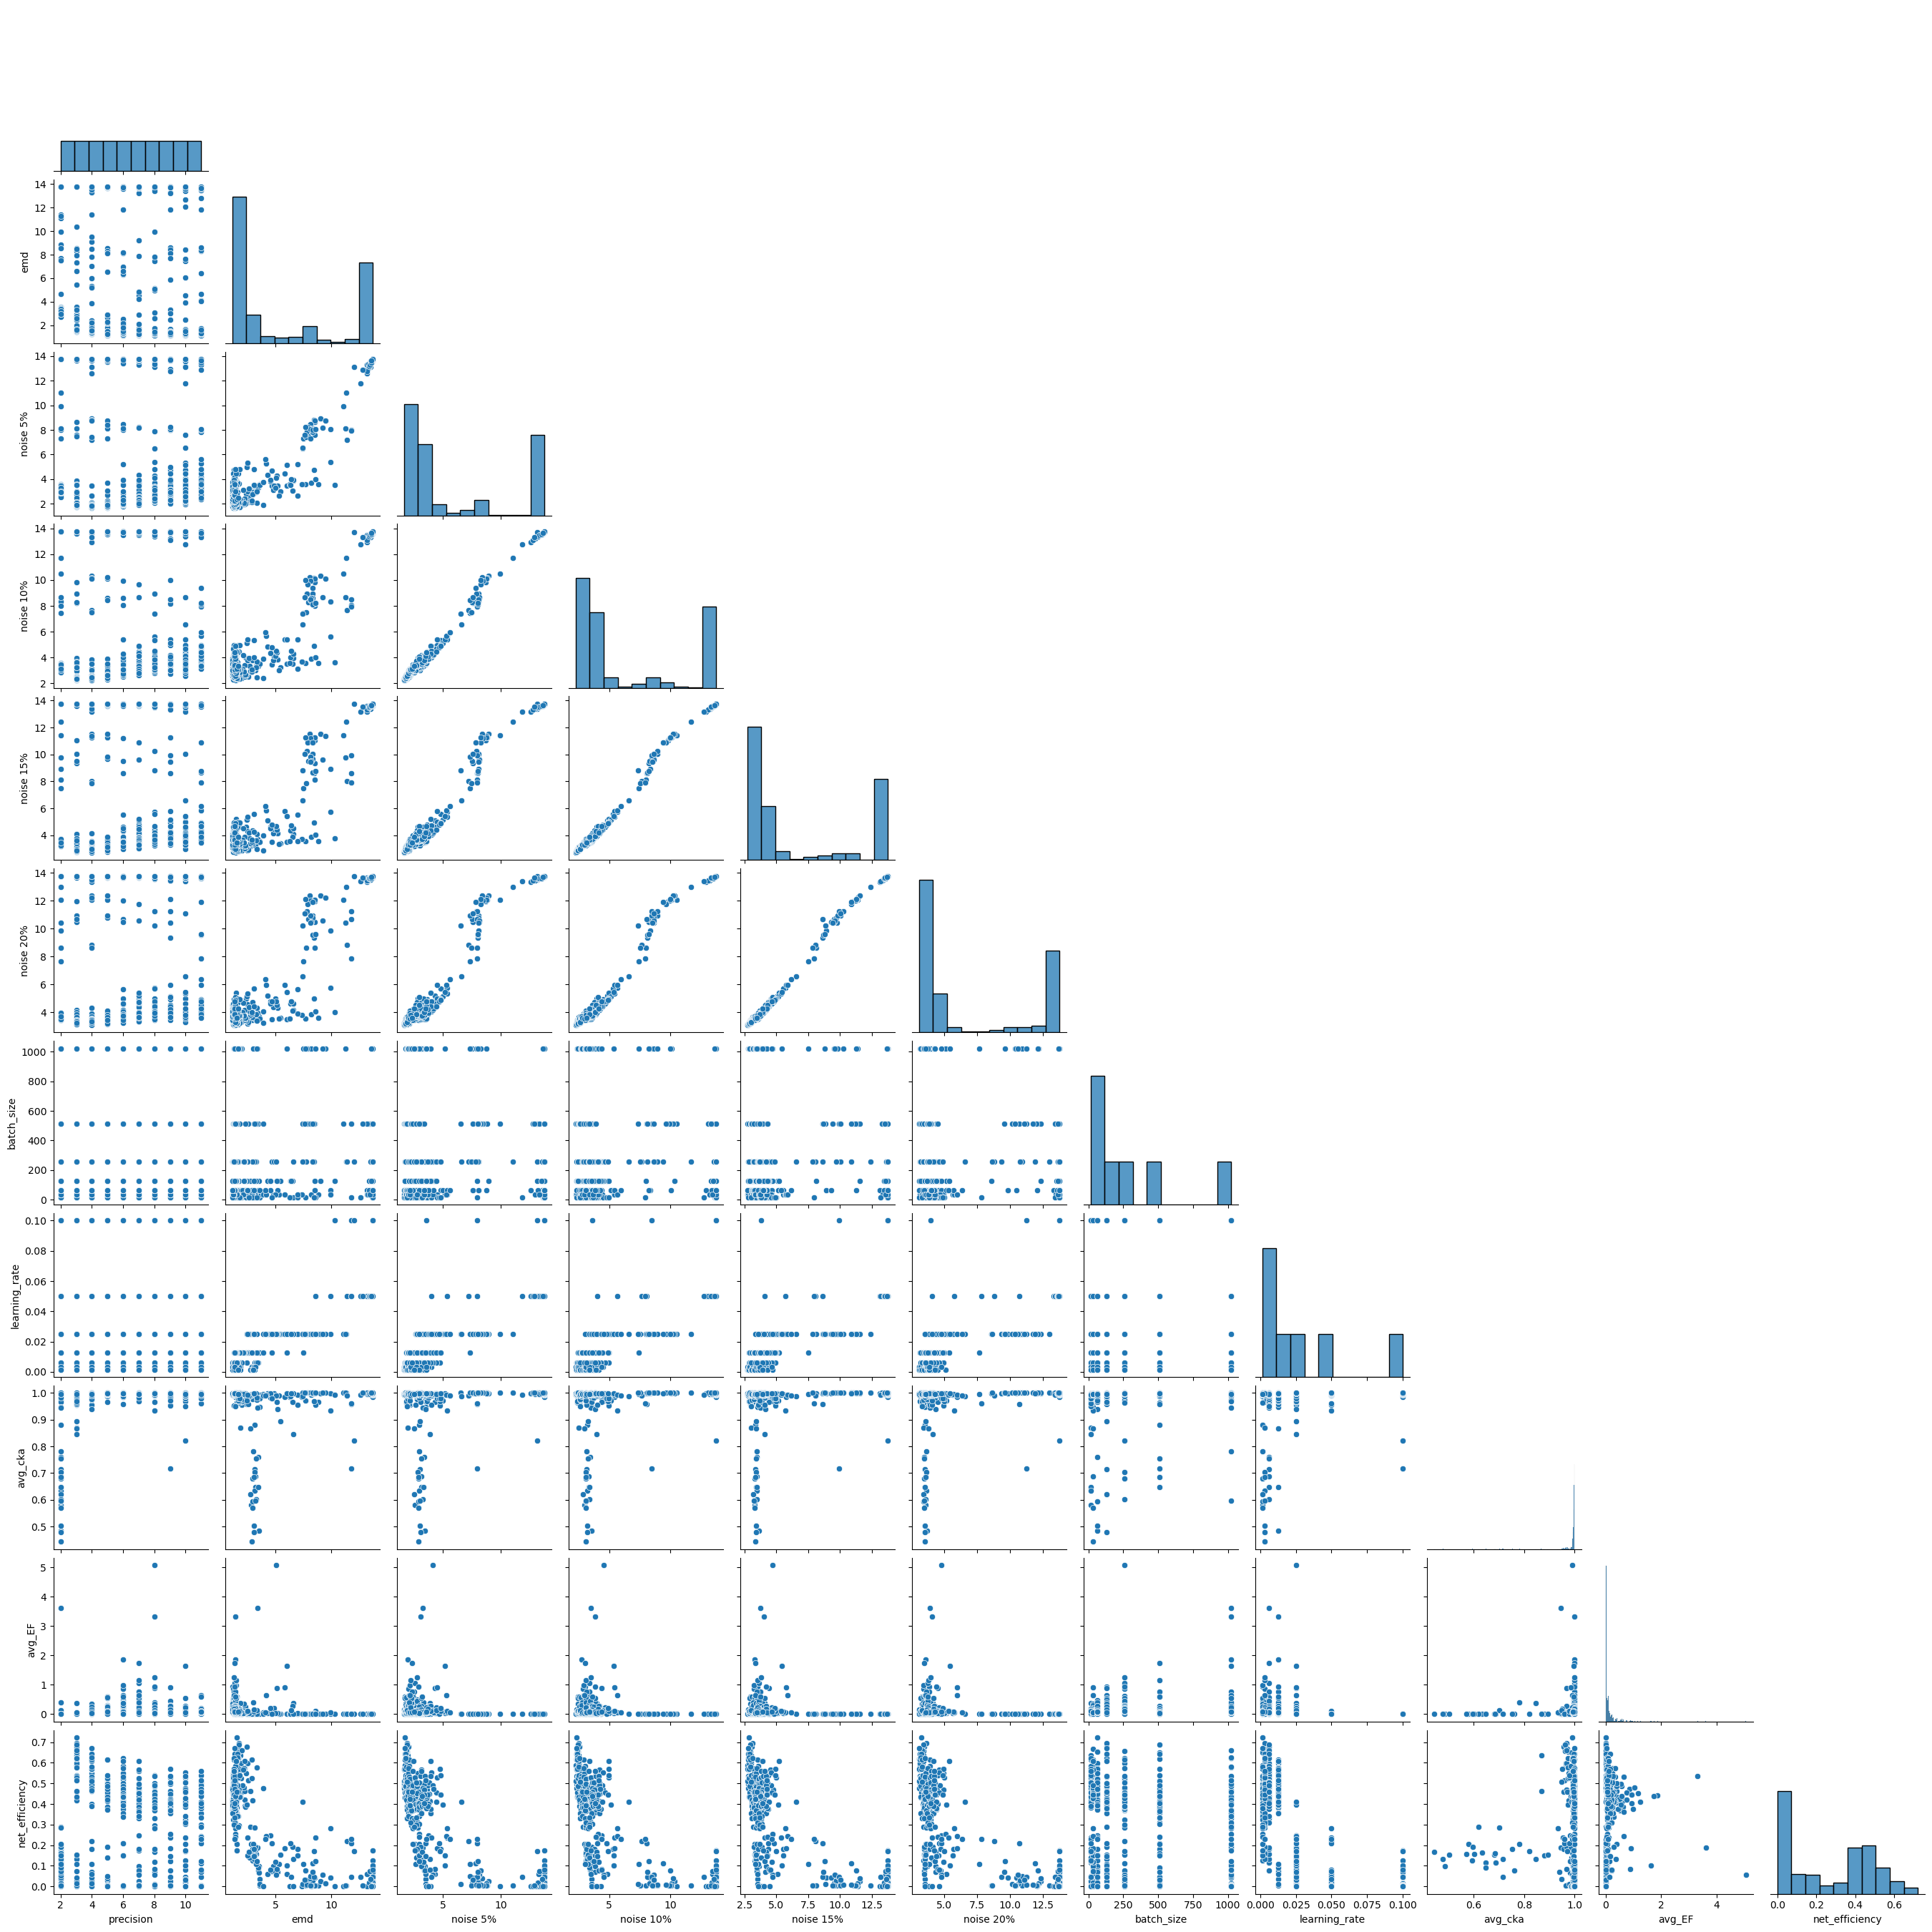

In [5]:
# dataset_df.drop(columns=['noise 10%', 'noise 15%', 'noise 20%'], inplace=True)
sns.pairplot(dataset_df, corner=True)
plt.show()

In [6]:
correlation_matrix = dataset_df.corr()

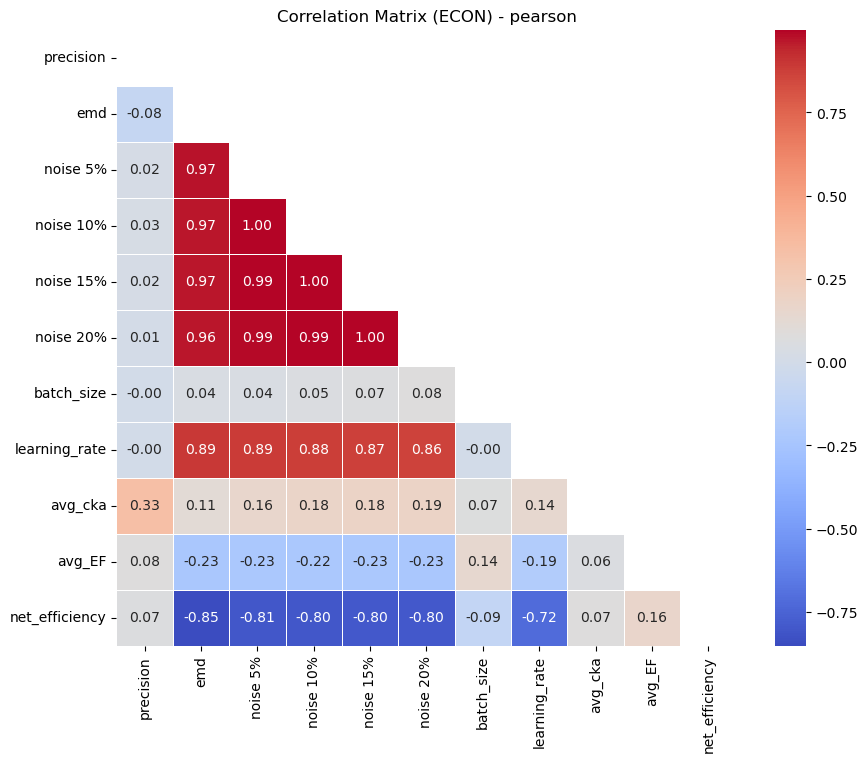

In [7]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (ECON) - pearson')
plt.show()

Check the logarithmic correlation:

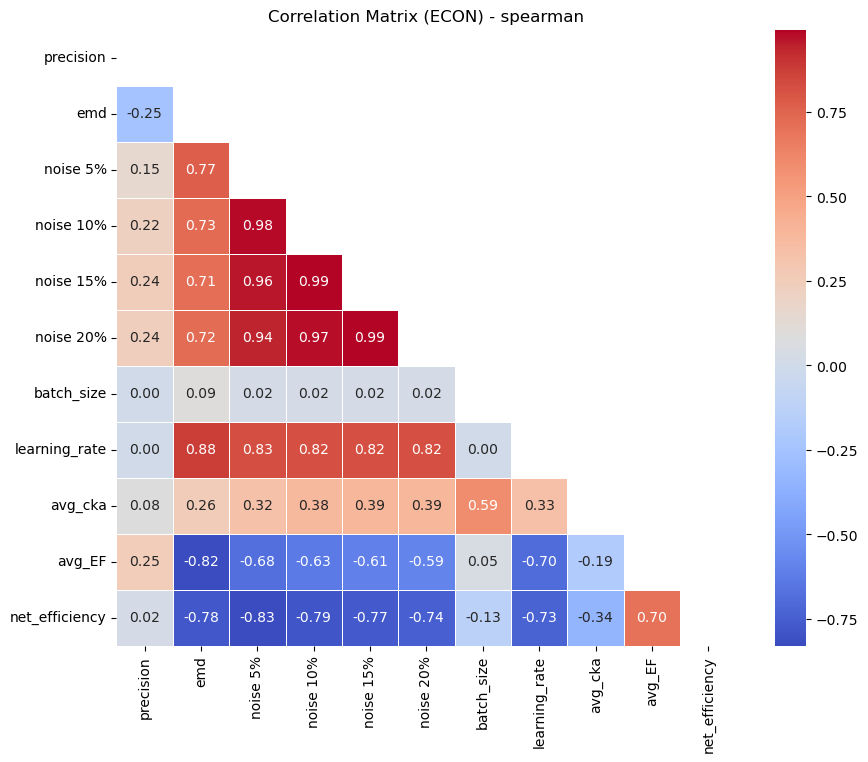

In [8]:
correlation_matrix = dataset_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (ECON) - spearman')
plt.show()

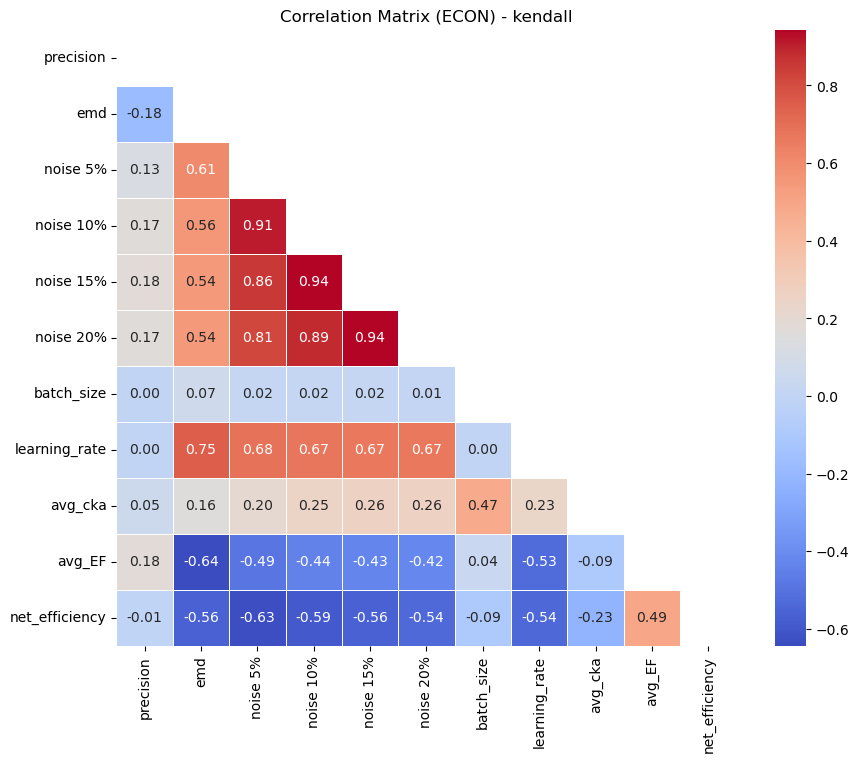

In [9]:
correlation_matrix = dataset_df.corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (ECON) - kendall')
plt.show()

# Effect of the quantization on the loss landscapes

In [10]:
DATA_PATH = '/home/jovyan/checkpoint/'

In [11]:
def get_loss_landscapes(batch_size, 
                        learning_rate, 
                        precision,
                        size, 
                        normalization,
                        steps, 
                        distance):
    '''
    Get the value of the Neural Efficiency
    '''
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/',
        f'plot_{normalization}_{steps}_{distance}.pkl'
    )
    try:
        f = open(path, "rb")
        data = pickle.load(f)
        f.close()
    except:
        print(path + ' Not found!')
        return False
    
    return data[f'plot_{normalization}_{steps}_{distance}']
    

In [12]:
BATCH_SIZE = 256
LEARNING_RATE = 0.025
NORMALIZATION = 'filter'
STEPS = 1800
DISTANCE = 1000
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

/tmp/ipykernel_2221345/3234999218.py:5: UserWarning: No contour levels were found within the data range.
  plot = plt.contour(loss_data, levels=20)


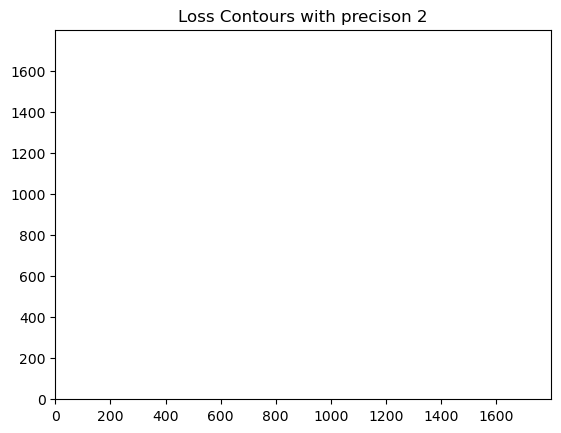

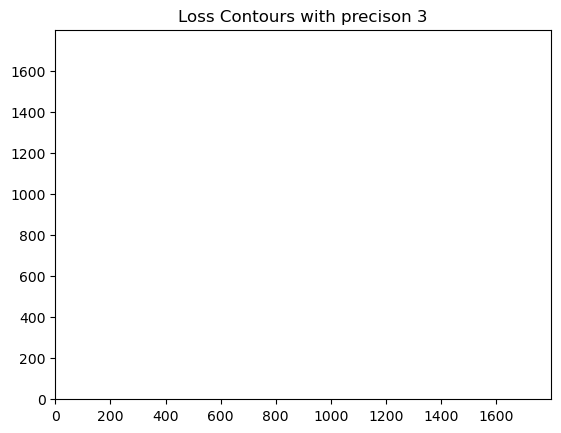

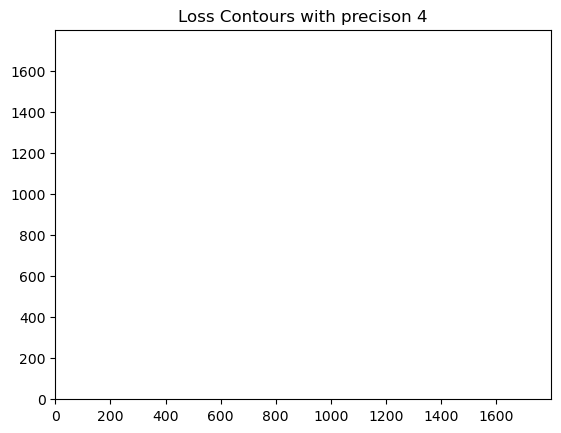

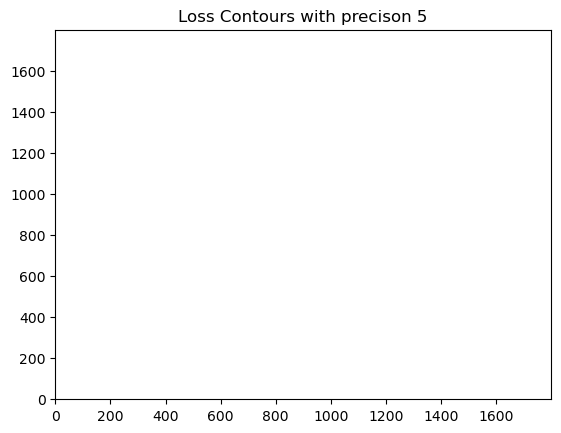

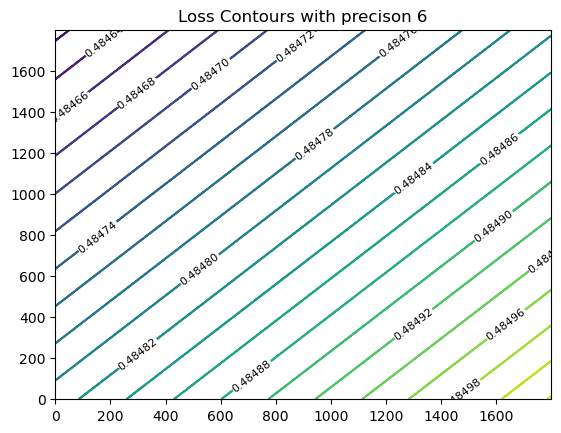

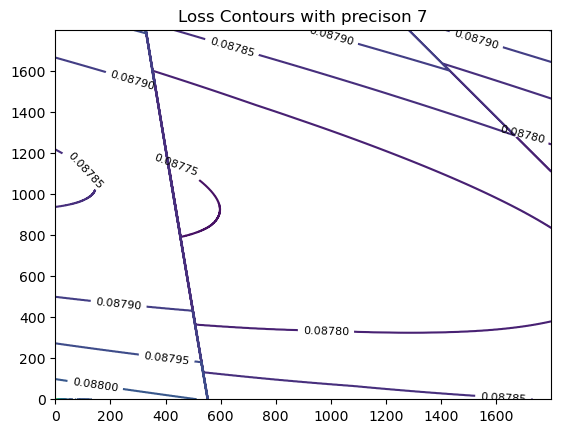

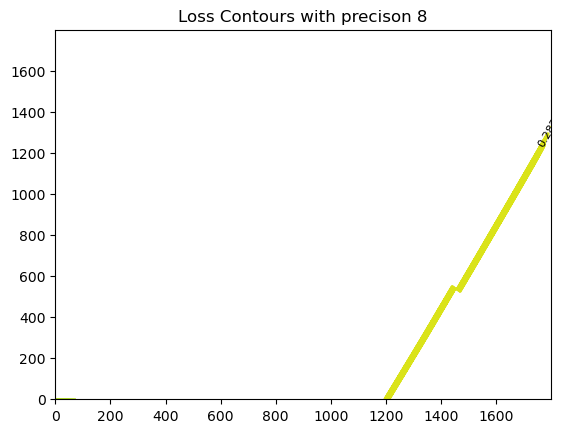

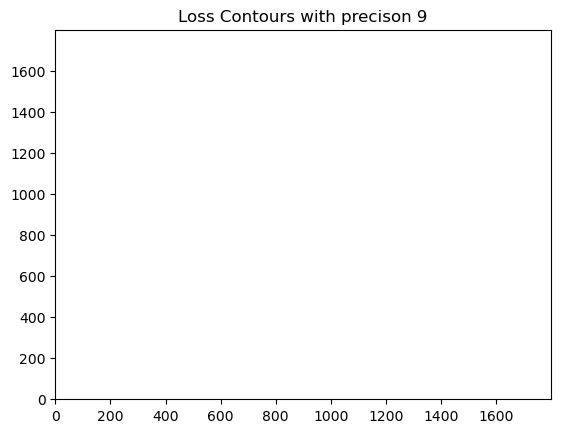

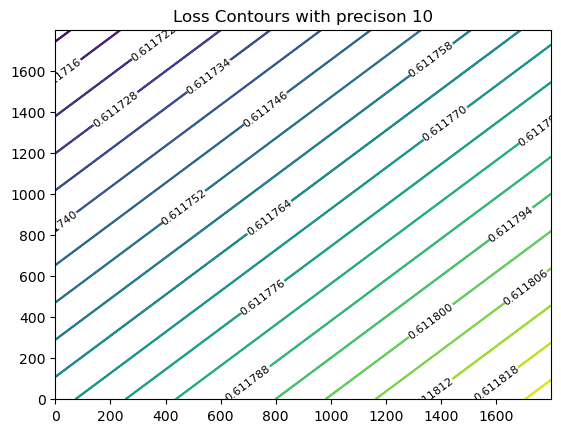

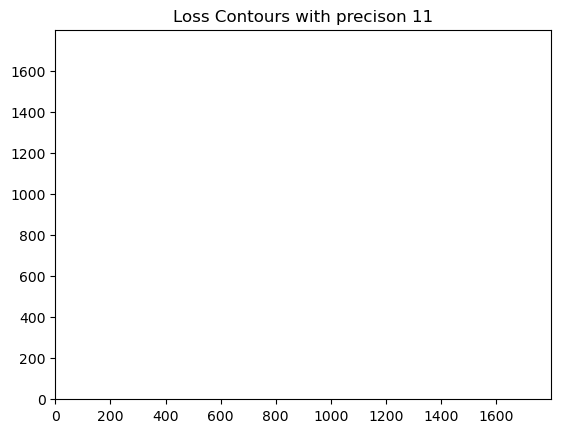

In [13]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']
    # plot 2D
    plot = plt.contour(loss_data, levels=20)
    plt.clabel(plot, inline=True, fontsize=8, colors='black')
    plt.title(f'Loss Contours with precison {p}')
    plt.show()
    


In [14]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']    
    # #plot 3D
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_title(f'Surface Plot with precison {p}')
    fig.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7efe026ba3a0> (for post_execute):


KeyboardInterrupt: 

# Features of the non-dominated solutions